# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

In [5]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

In [17]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.functional as F

from stepbystep.v0 import StepByStep

# A Simple Classification Problem

## Data Generation

In [18]:
X, y = make_moons(
    n_samples=100,
    noise=0.3,
    random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=13
)

In [19]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

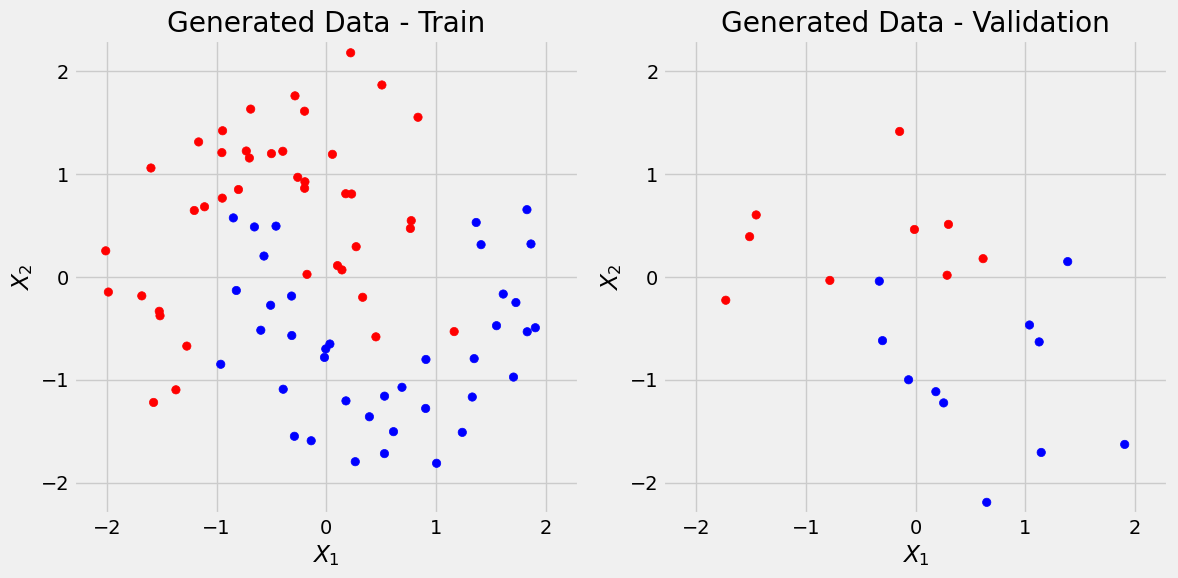

In [20]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [81]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
print(x_train_tensor.shape, y_train_tensor.shape)

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()
print(x_val_tensor.shape, y_val_tensor.shape)

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

torch.Size([80, 2]) torch.Size([80, 1])
torch.Size([20, 2]) torch.Size([20, 1])


## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [23]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [24]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

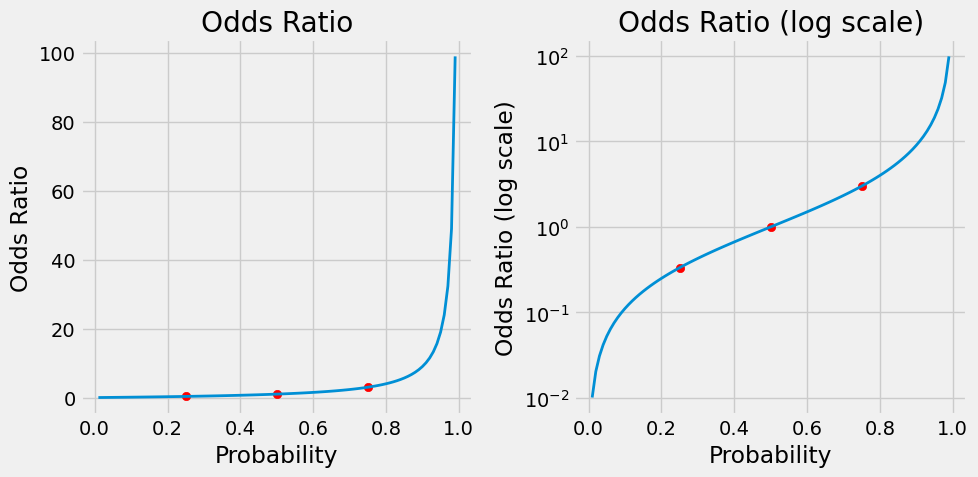

In [25]:
fig = figure2(p)

### Log Odds Ratio

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

其中，$z = log(\frac{p}{1 - p})$又称为`Logit`函数。

In [26]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = 0.75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

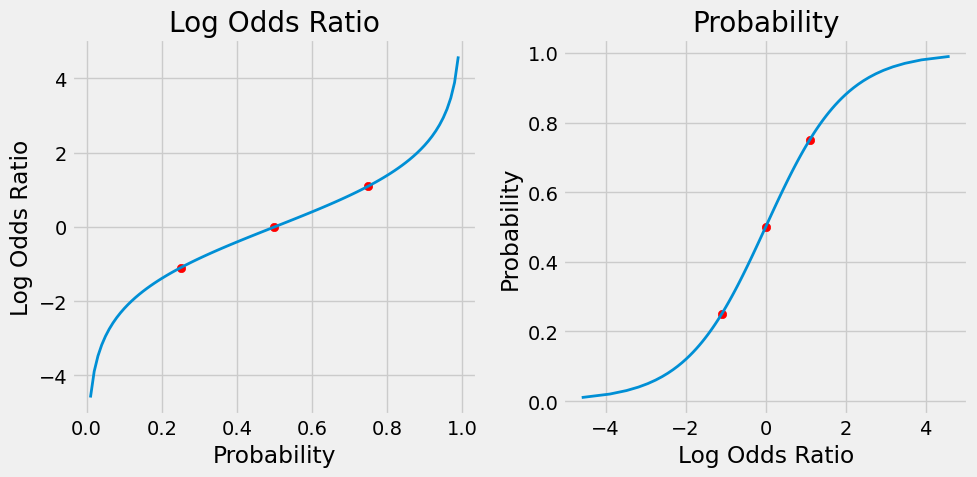

In [27]:
fig = figure3(p)

### From Logits to Probabilities

从Logits到概率的过程其实本质上就是从Logit函数到Sigmoid函数的过程，其实，Logit函数和Sigmoid函数互为反函数：

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = 0.75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

In [31]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

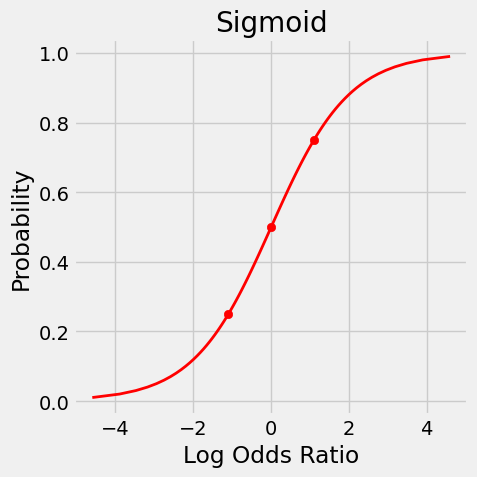

In [32]:
fig = figure4(p)

### Logistic Regression

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](images/logistic_model.png)

In [33]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module("linear", nn.Linear(2, 1))
model1.add_module("Sigmoid", nn.Sigmoid())
print(model1.state_dict())

OrderedDict({'linear.weight': tensor([[0.5406, 0.5869]]), 'linear.bias': tensor([-0.1657])})


### A Note on Notation

向量化表示：

In [63]:
%%latex
\begin{aligned}
\Large W &=
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X =
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
\end{aligned}

\begin{aligned}
\Large
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}

<IPython.core.display.Latex object>

## Loss

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

In [41]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([0.9, 0.2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]  # that means dummy_predictions[0]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [42]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [43]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

In [46]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT：先Y后T
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

In [47]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [48]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [49]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In [50]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large \text{pos\_weight} = \frac{\text{points in negative class}}{\text{points in positive class}}
$$

In [68]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [69]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [70]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large \text{weighted average} = \frac{\text{pos\_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos\_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos\_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

In [27]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [74]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module("linear", nn.Linear(2, 1))

# Defines BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

# Defines as SGD optimizer to update the parameters
optimizer = optim.SGD(params=model.parameters(), lr=lr)

## Model Training

In [82]:
n_epochs = 100

sbs = StepByStep(model=model, loss_fn=loss_fn, optimizer=optimizer)
sbs.set_loaders(train_loader=train_loader, val_loader=val_loader)
sbs.train(n_epochs=n_epochs)

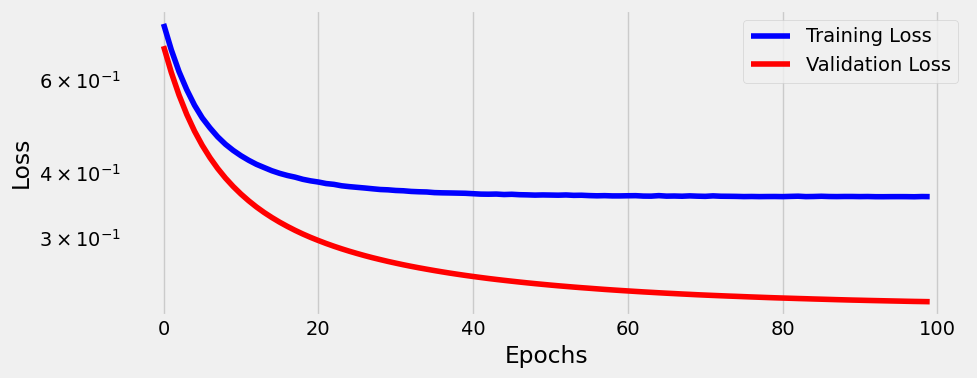

In [83]:
fig = sbs.plot_losses()

In [84]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 1.1806, -1.8693]]), 'linear.bias': tensor([-0.0591])})


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

#### Making Predictions (Logits)

In [85]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933174 ],
       [-1.2334073 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [86]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757151 ],
       [0.22558564]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [87]:
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

In [88]:
(probabilities >= 0).astype(int)

array([[1],
       [1],
       [1],
       [1]])

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

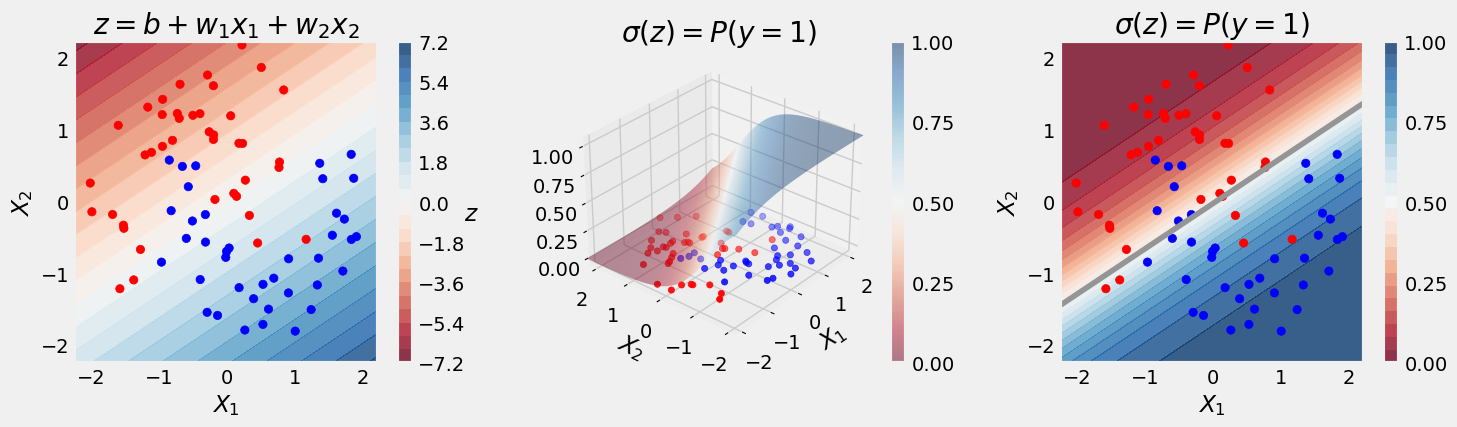

In [89]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

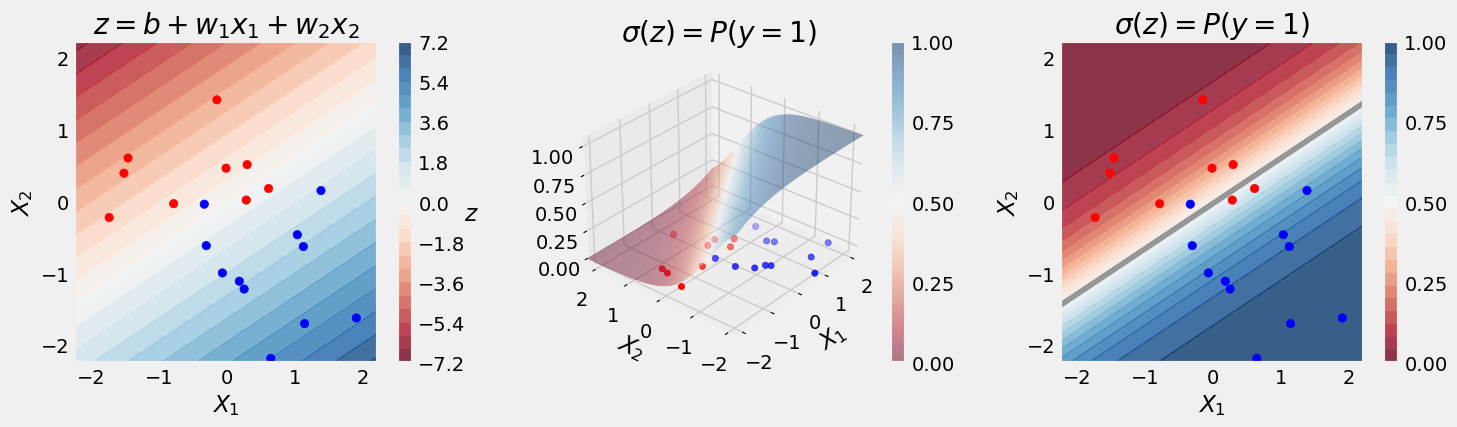

In [90]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

### Are my data points separable?

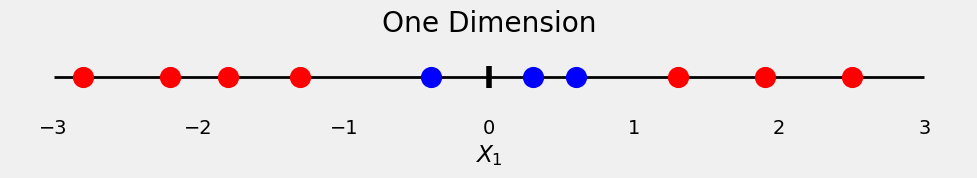

In [91]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

$$
\Large X_2 = f(X_1)= X_1^2
$$

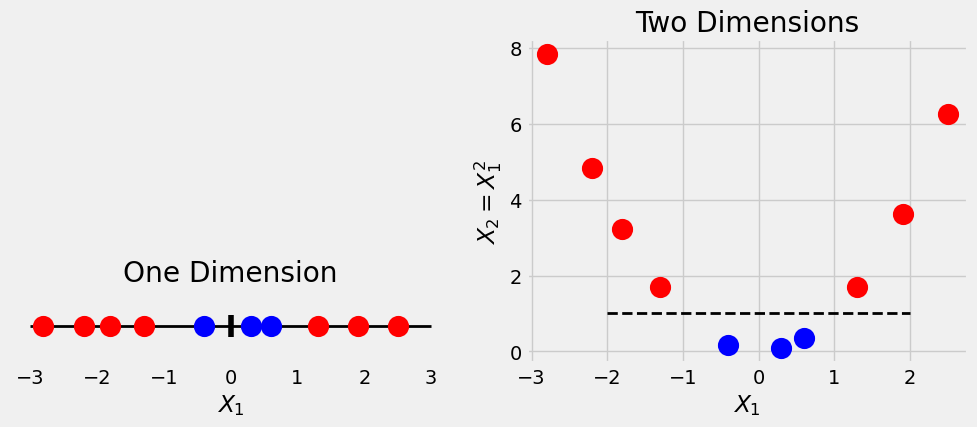

In [92]:
fig = two_dimensions(x, y)

In [93]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold

In [95]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

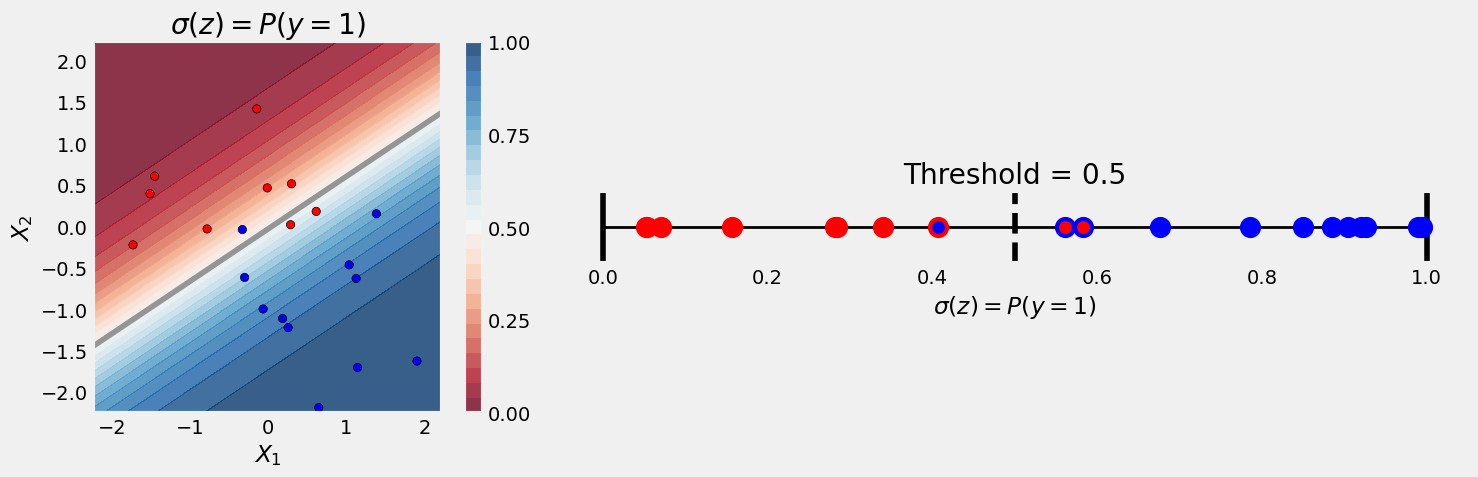

In [96]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

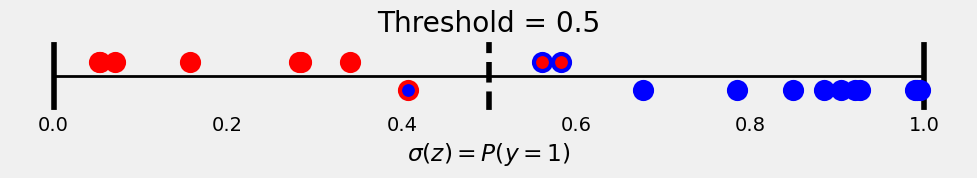

In [97]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

### Confusion Matrix

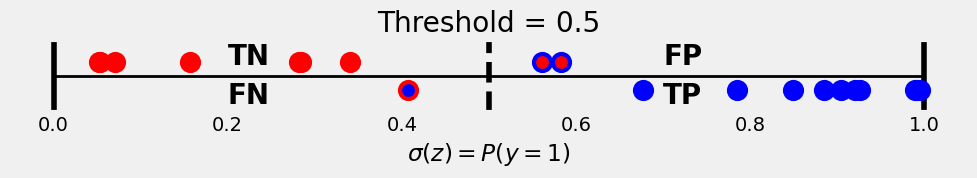

In [98]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [99]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

#### True and False Positives and Negatives

In [100]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [101]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [102]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [48]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [49]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### F1 Score

$$
F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
$$

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

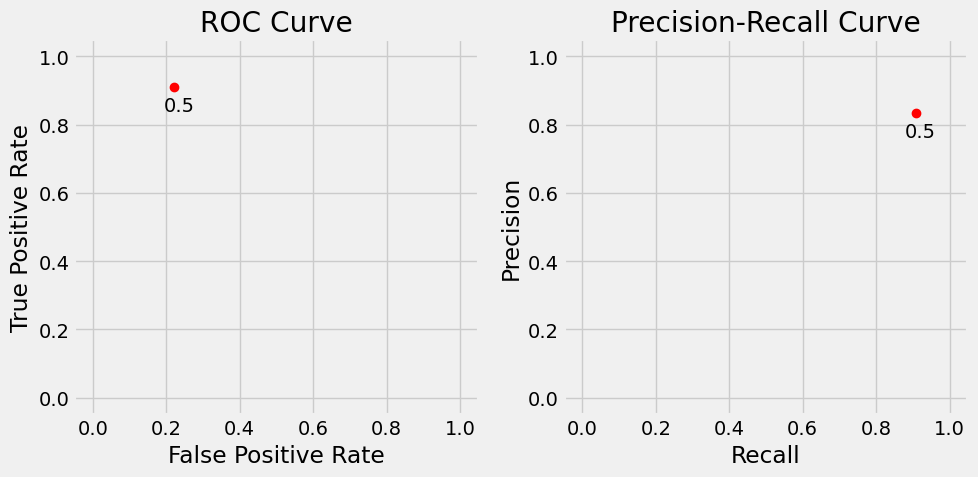

In [103]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

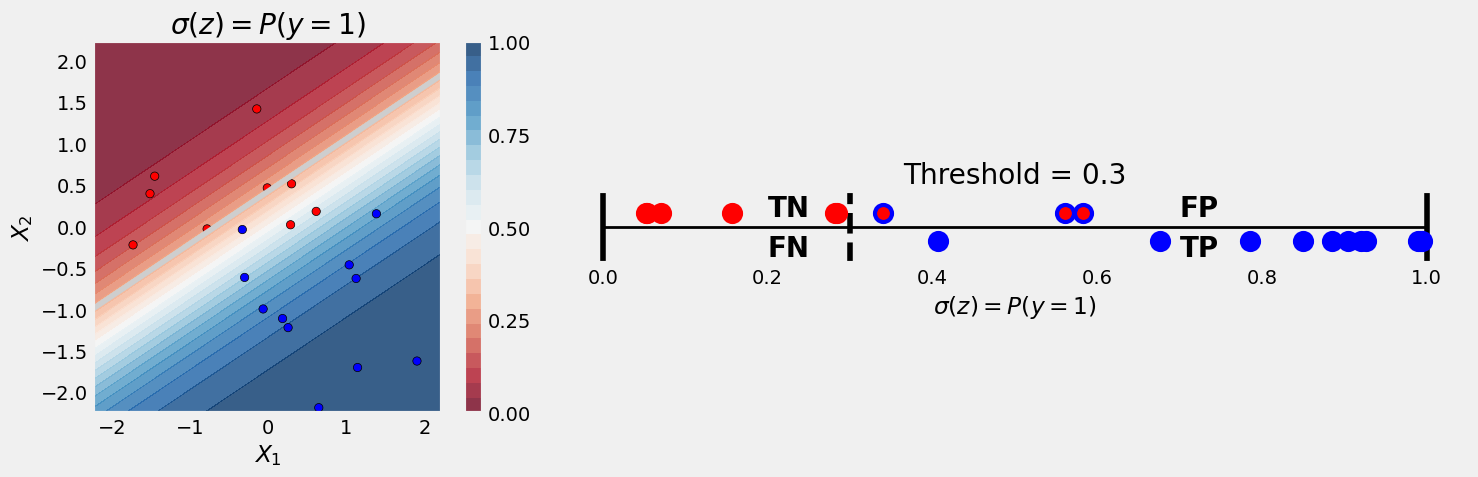

In [104]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [105]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

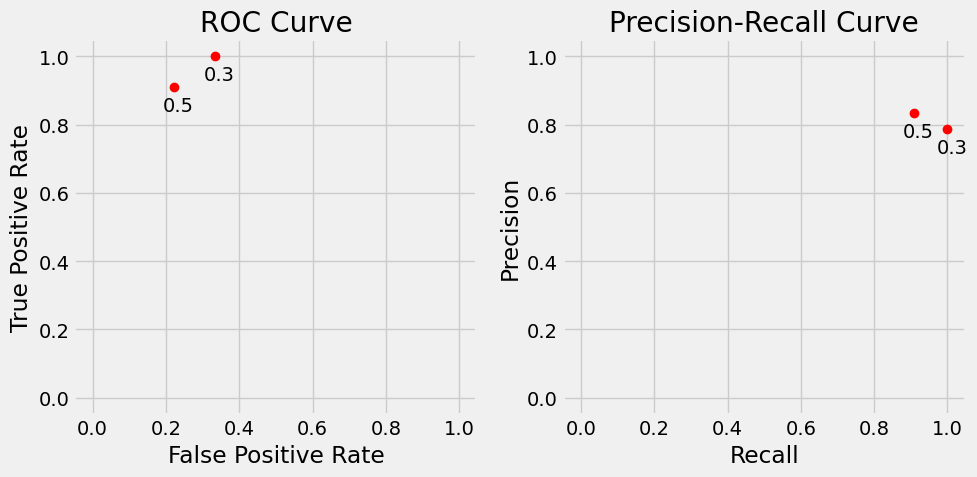

In [106]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

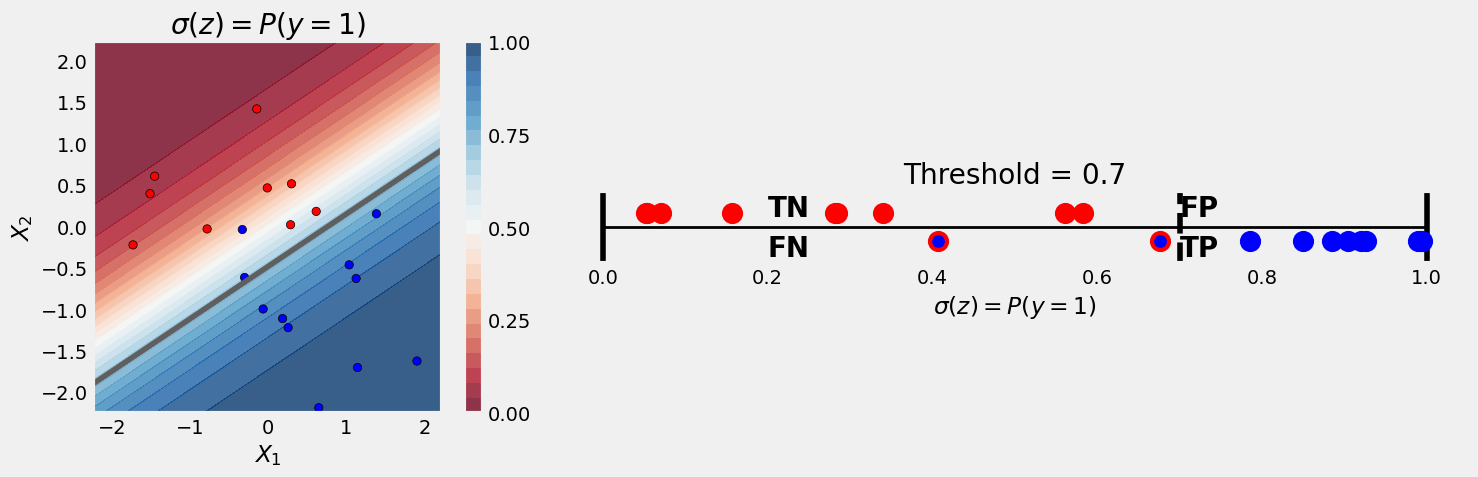

In [107]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [108]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

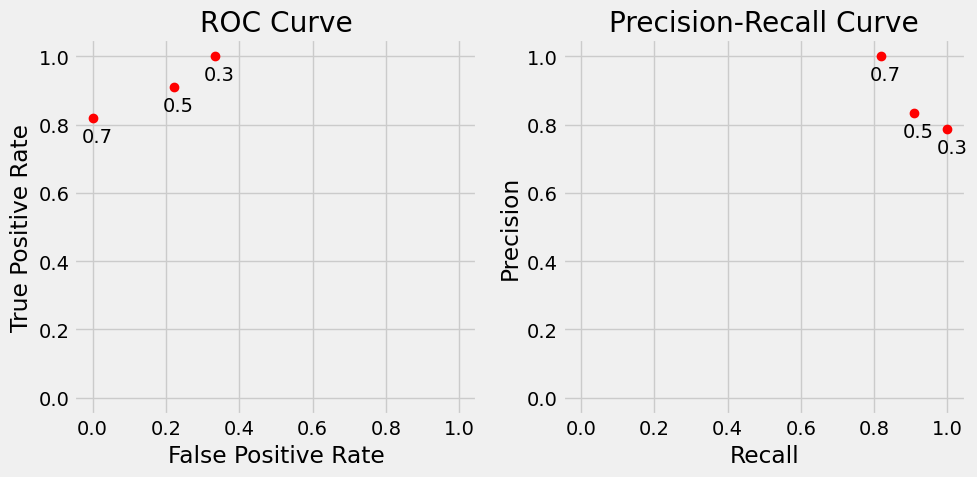

In [109]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [110]:
threshs = np.linspace(0.,1,11)

/Users/eassi/ws/py/dl/pytorch_step_by_step/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


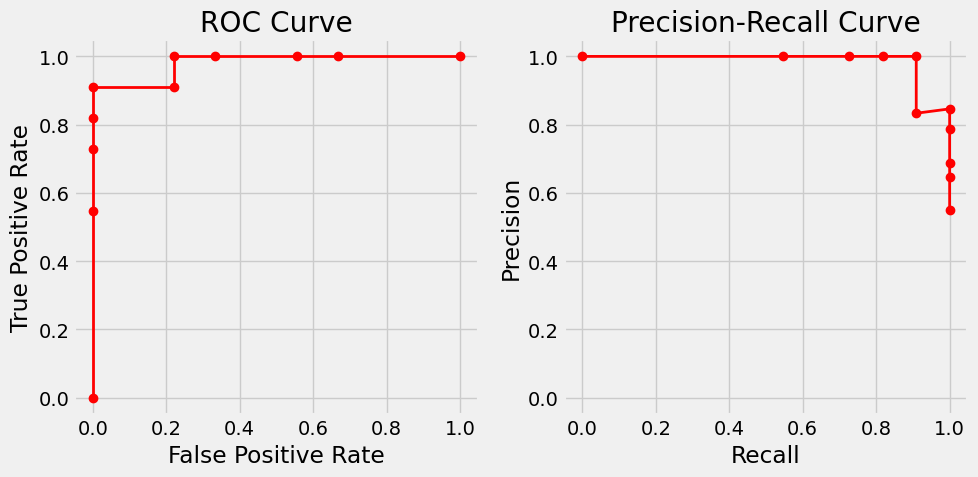

In [111]:
fig = figure17(y_val, probabilities_val, threshs)

In [112]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

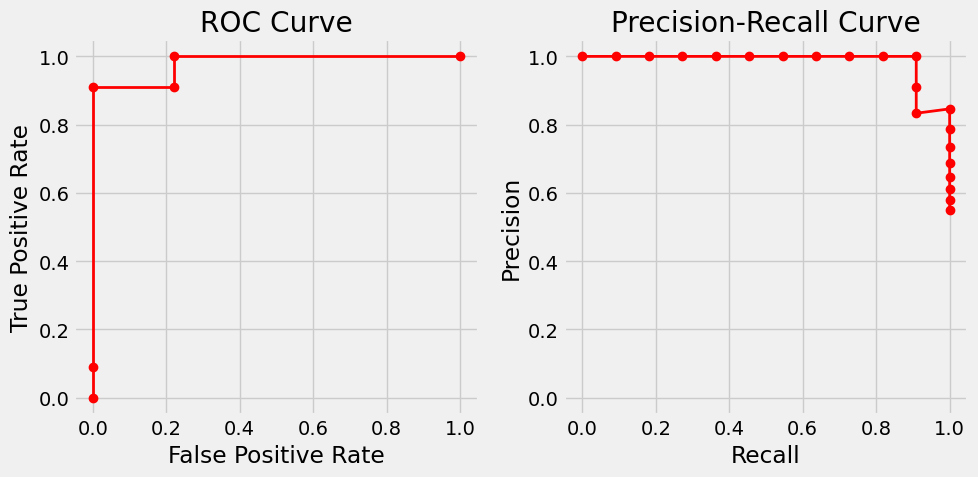

In [113]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

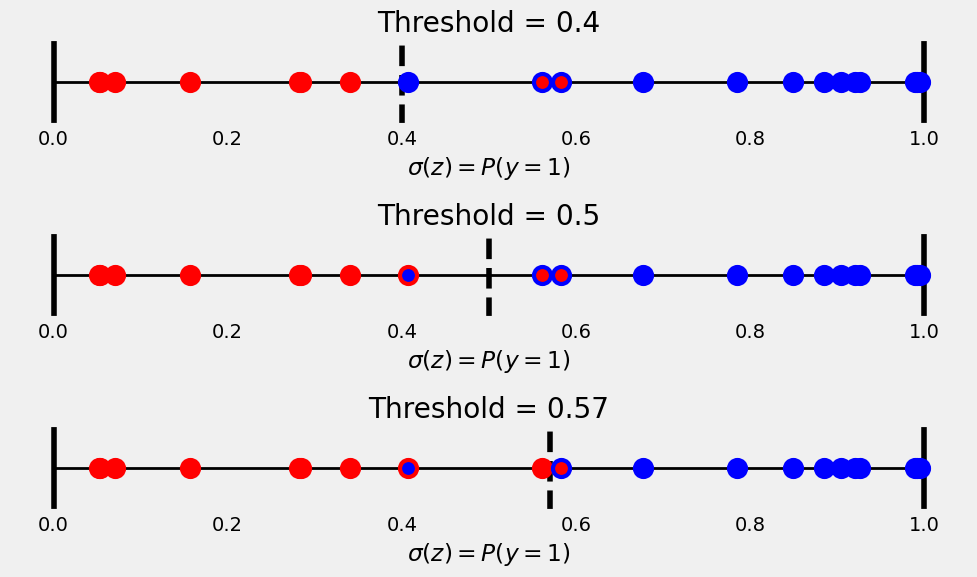

In [114]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

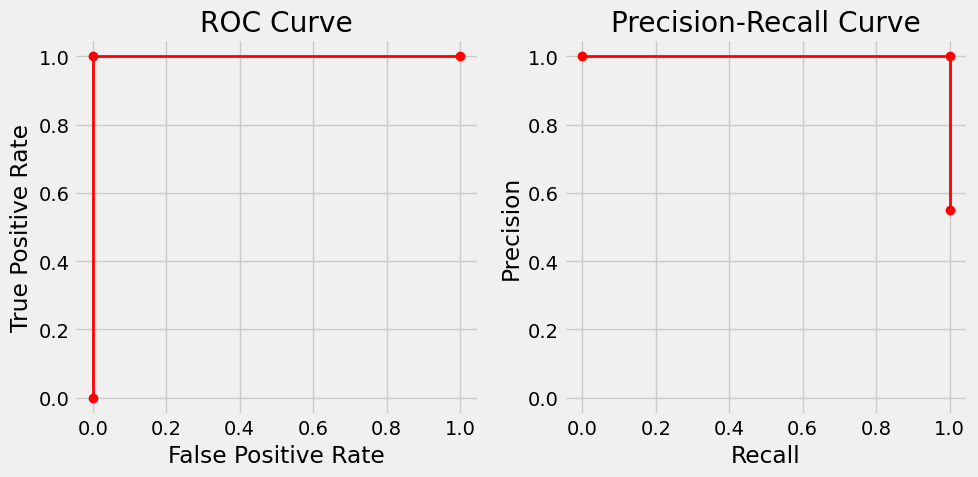

In [115]:
# Best
fig = figure20(y_val)

In [116]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [117]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

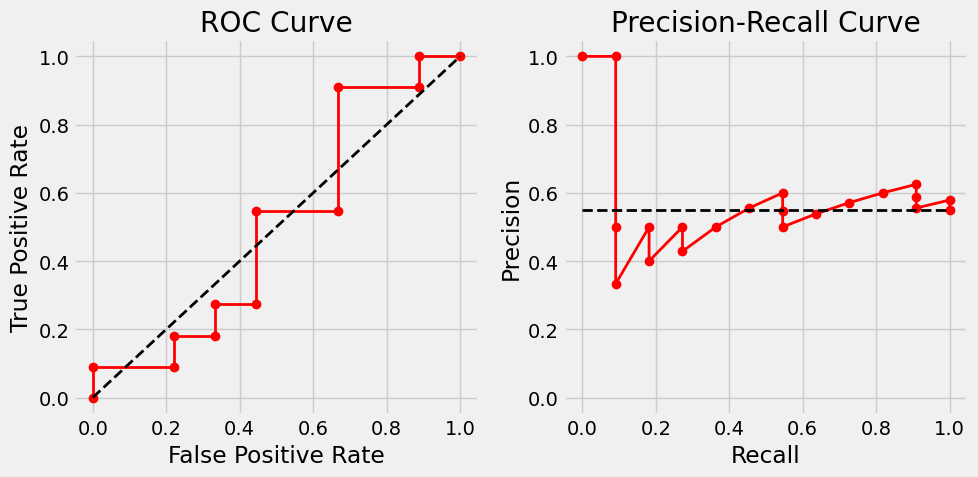

In [118]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [119]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [120]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [121]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [122]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [123]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [124]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 1.1806, -1.8693]]), 'linear.bias': tensor([-0.0591])})


In [125]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])